In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [96]:
df = pd.read_excel("updated_df.xlsx")
cleaned_df = df.copy()

In [97]:
def config_colour(plotted_values, colour_values, small_num = 10e-10, colour_scheme = 'viridis'):
    
    normalised_val = (sorted(colour_values) - min(colour_values))/(max(colour_values) - min(colour_values))

    normalised_val[0] += small_num
    normalised_val[-1] -= small_num
    idx = np.argsort(plotted_values)
    normalised_val = normalised_val[idx]
    
    change_to_colour = plt.get_cmap(colour_scheme)
    
    return change_to_colour(normalised_val)

## Data Cleaning / Feature Engineering

#### Examining distribution of games features:

In [98]:
df.head(1)

,ID,Name,Year,Rank,Bayes average,average,averageweight,boardgamemechanic,maxplayers,maxplaytime,minage,minplayers,minplaytime,numcomments,numweights,owned,playingtime,stddev,usersrated,price
0,174430,Gloomhaven,2017,1,8.611,8.89906,3.793,"['Campaign / Battle Card Driven', 'Cooperative...",4,120,12,1,60,4995,1082,41470,120,1.6027,25289,88.95


In [99]:
features_to_examine = [i for i in df]
to_remove = ['Name', 'ID', 'boardgamemechanic']
for j in to_remove:
    features_to_examine.remove(j)
print(features_to_examine)

['Year', 'Rank', 'Bayes average', 'average', 'averageweight', 'maxplayers', 'maxplaytime', 'minage', 'minplayers', 'minplaytime', 'numcomments', 'numweights', 'owned', 'playingtime', 'stddev', 'usersrated', 'price']


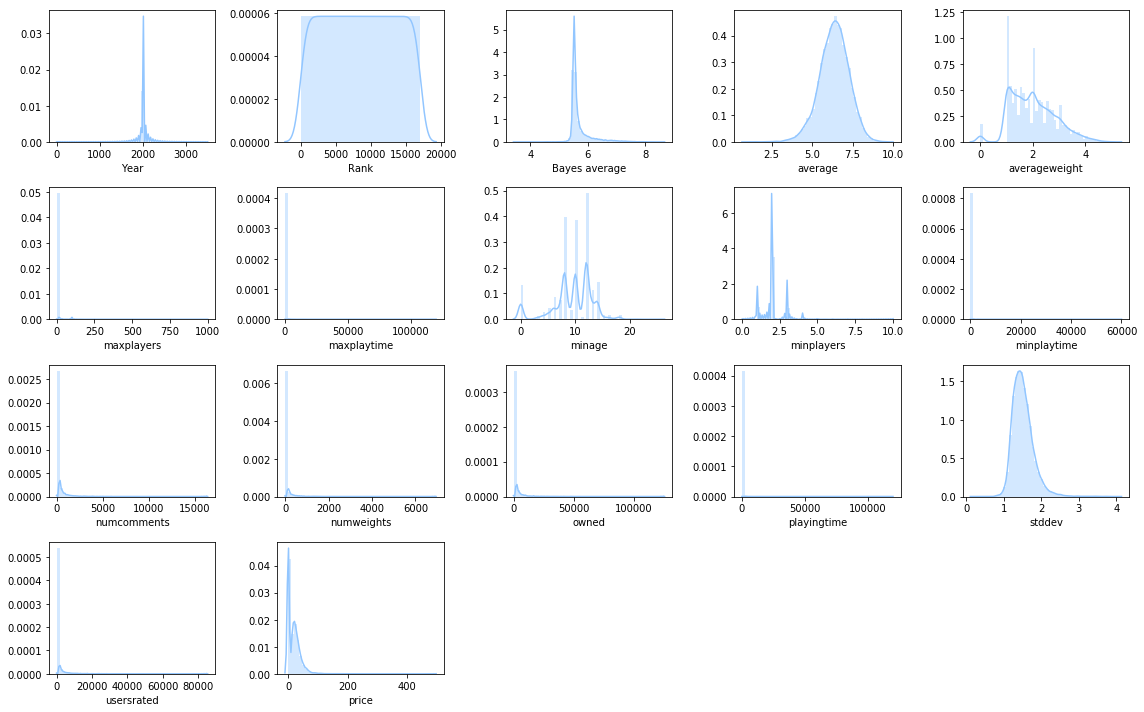

In [100]:
fig = plt.figure(figsize = (16, 10))
j = 0
for feat in features_to_examine: 
    plt.subplot(4, 5, j + 1)
    j += 1
    sns.distplot(df[feat])
fig.tight_layout()
plt.show()

It can be seen that outside the features that have bounded values (eg. average, averageweight), a lot of the measurements show a massive range of values. Part of the issue in this is that some are boundless. For instance, some games can take an endless amount of time without ever starting a new game, thus the Max Play Time is set to something outrageous like 120000 minutes. 


Other issues: 
* Weight seems to span 1-5 opposed to 0-5, with no games taking on a value 0<value<1. 
* Price - Has a funny distribution as it is including the games that a price was not found for.
* Max Players and Min/Max Playtime - both cater to games which have an unbounded number of players/play length without a consistent 
* Boardgames with years in the future

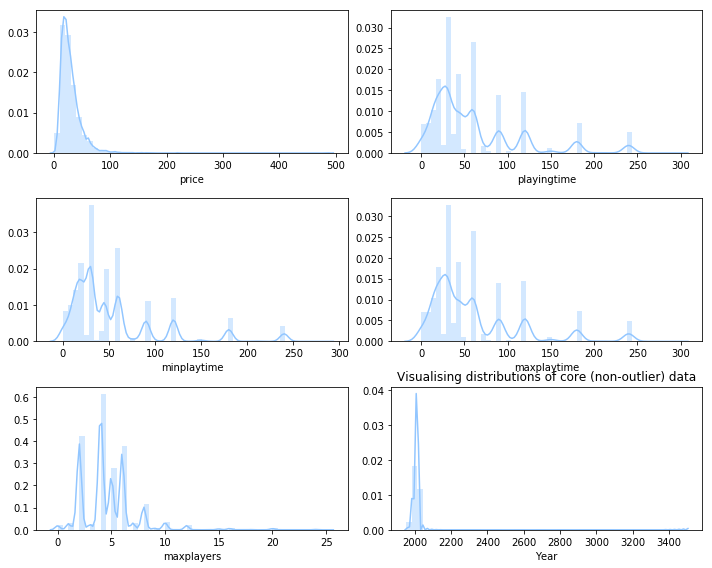

In [101]:
# Examining what the distributions might look like with outliers accounted for

fig = plt.figure(figsize = (10, 8))
rows = 3
cols = 2

plt.subplot(rows, cols, 1)
sns.distplot(df[df["price"] > 0].price)

plt.subplot(rows, cols, 2)
sns.distplot(df[df["playingtime"] < 300].playingtime)

plt.subplot(rows, cols, 3)
sns.distplot(df[df["minplaytime"] < 300].minplaytime)

plt.subplot(rows, cols, 4)
sns.distplot(df[df["maxplaytime"] < 300].maxplaytime)

plt.subplot(rows, cols, 5)
sns.distplot(df[df["maxplayers"] < 30].maxplayers)

plt.subplot(rows, cols, 6)
sns.distplot(df[df["Year"] > 1950 ].Year)

plt.tight_layout()
plt.title("Visualising distributions of core (non-outlier) data")
plt.show()

### Games with prices found

In [102]:
# Only interested in games which have a price associated. 
cleaned_df = cleaned_df[cleaned_df.price > 0]

### Game Age

In [103]:
current_year = 2020
print("Number of games made, apparently, in the future: {}".format(len(cleaned_df[cleaned_df.Year > current_year])))
cleaned_df[cleaned_df.Year > current_year].head()

Number of games made, apparently, in the future: 3


,ID,Name,Year,Rank,Bayes average,average,averageweight,boardgamemechanic,maxplayers,maxplaytime,minage,minplayers,minplaytime,numcomments,numweights,owned,playingtime,stddev,usersrated,price
134,188,Go,2200,135,7.357,7.64399,3.9909,['Area Enclosure'],2,180,8,2,30,3412,1314,17915,180,1.91083,13238,18.59
1178,2397,Backgammon,3000,1179,6.363,6.52820,2.0207,"['Betting/Wagering', 'Dice Rolling', 'Roll / S...",2,30,8,2,30,2758,868,15192,30,1.59618,10303,10.61
6242,2399,Senet,3500,6243,5.605,5.91536,1.4833,"['Dice Rolling', 'Roll / Spin and Move']",2,30,6,2,30,269,60,1143,30,1.60037,560,28.23


It can be seen that the games that are apparently built in the future are actually some of the oldest games in history. The error has likely arisen due to the dataset not taking into account AD vs BC with the year.
The way I plan on resolving this is through making their Year negative. 

In [104]:
# Converting it to BC Year
cleaned_df.Year = cleaned_df.Year.apply(lambda x: -x if x > current_year else x)

When looking at the distribution still it is wildly split. To make a cleaner distribution, the model is going to focus on "modern" boardgames, that is, anything released after 1950. 

In [105]:
# Dropping older games
year_cap = 1950

cleaned_df = cleaned_df.drop(cleaned_df[cleaned_df.Year < year_cap].index)

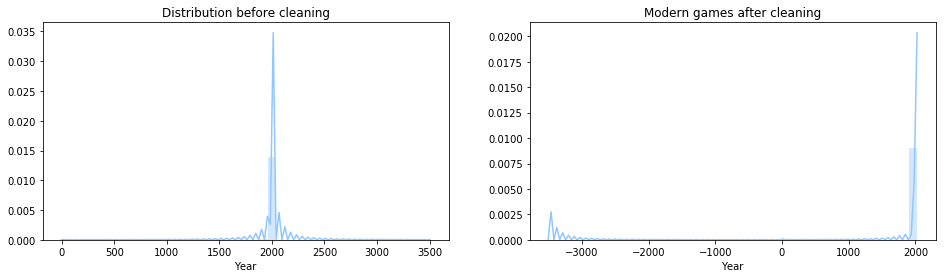

In [106]:
fig = plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
sns.distplot(df.Year)
plt.title("Distribution before cleaning")

plt.subplot(1, 2, 2)
plt.title("Modern games after cleaning")
sns.distplot(cleaned_df.Year)
plt.show()

### Max Players

In [107]:
player_count_cap = 30
max_players_df = cleaned_df[cleaned_df.maxplayers > player_count_cap]
print("Number of games that can play with more than {} players: {}".format(player_count_cap, len(max_players_df)))

Number of games that can play with more than 30 players: 68


There are plenty of games which can play with an apparently boundless number of people. These are often party games catering to larger groups. Unfortunately, some of these games have been labeled inconsistently, many "maxing out" at 99, whilst others at 999. We are going to see how the distribution is effected if we cap them at 99 and then go from there. 

In [108]:
cleaned_df.maxplayers = df.maxplayers.apply(lambda x: player_count_cap if x > player_count_cap else x)

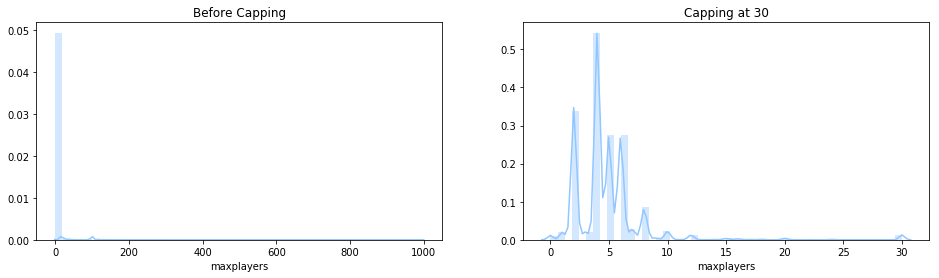

In [109]:
plt.figure(figsize = (16, 4))

plt.subplot(1, 2, 1)
sns.distplot(df.maxplayers)
plt.title("Before Capping")

plt.subplot(1, 2, 2)
sns.distplot(cleaned_df.maxplayers)
plt.title("Capping at {}".format(player_count_cap))

plt.show()

It can be seen that even adjusting the max player count to be a maximum of 30, it does not distrupt the distribution significantly. This is due to games which are limitless in the number of players making up a sliver of the data.

### Playtime

Again, typical playtime suffers when games do not necessarily have a defined end and thus could go on "forever". These games are far and few in between but I am going to cap their values to reduce how significantly they are outliers from the rest of the data. 

In [110]:
min_playtime_cap = 10 * 60 
max_playtime_cap = 20 * 60
playtime_cap = 8 * 80

max_playtime_df = cleaned_df[cleaned_df.maxplaytime > max_playtime_cap]
min_playtime_df = cleaned_df[cleaned_df.minplaytime > min_playtime_cap]
playtime_df = cleaned_df[cleaned_df.playingtime > playtime_cap]

In [111]:
print("Number of games with a max playtime above {} mins: {}".format(max_playtime_cap, len(max_playtime_df)))
print("Number of games with a min playtime above {} mins: {}".format(min_playtime_cap, len(min_playtime_df)))
print("Number of games with a playtime above {} mins: {}".format(playtime_cap, len(playtime_df)))

Number of games with a max playtime above 1200 mins: 39
Number of games with a min playtime above 600 mins: 32
Number of games with a playtime above 640 mins: 90


In [112]:
cleaned_df.maxplaytime = cleaned_df.maxplaytime.apply(lambda x : max_playtime_cap if x > max_playtime_cap else x)
cleaned_df.minplaytime = cleaned_df.minplaytime.apply(lambda x : min_playtime_cap if x > min_playtime_cap else x)
cleaned_df.playingtime= cleaned_df.playingtime.apply(lambda x : playtime_cap if x > playtime_cap else x)

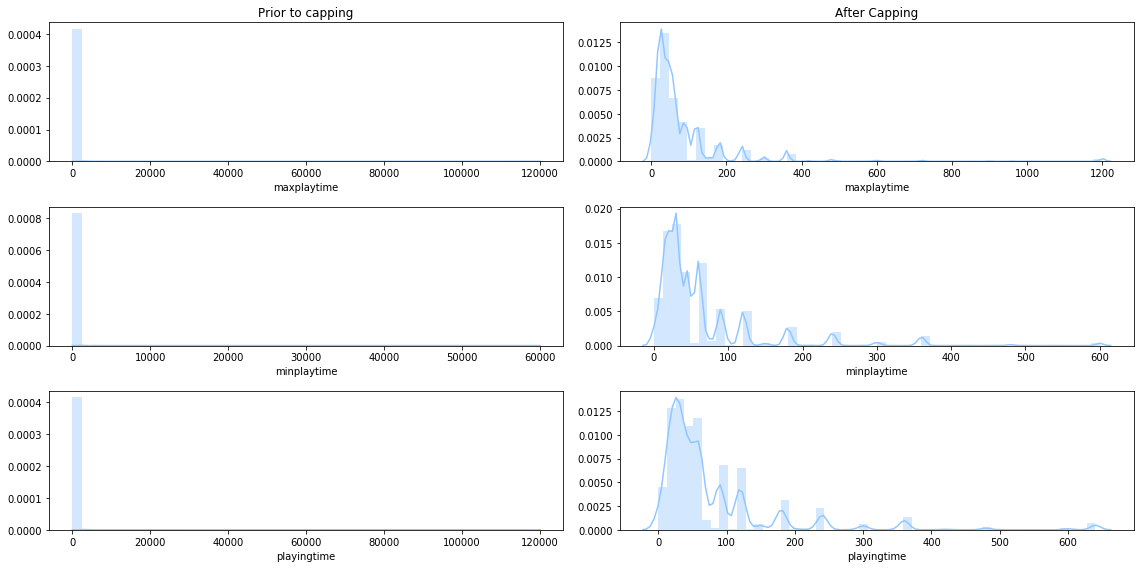

In [113]:
fig = plt.figure(figsize = (16, 8))

rows = 3
cols = 2

plt.subplot(rows, cols, 1)
sns.distplot(df.maxplaytime)
plt.title("Prior to capping")

plt.subplot(rows, cols, 2)
sns.distplot(cleaned_df.maxplaytime)
plt.title("After Capping")

plt.subplot(rows, cols, 3)
sns.distplot(df.minplaytime)


plt.subplot(rows, cols, 4)
sns.distplot(cleaned_df.minplaytime)

plt.subplot(rows, cols, 5)
sns.distplot(df.playingtime)

plt.subplot(rows, cols, 6)
sns.distplot(cleaned_df.playingtime)

plt.tight_layout()
plt.show()

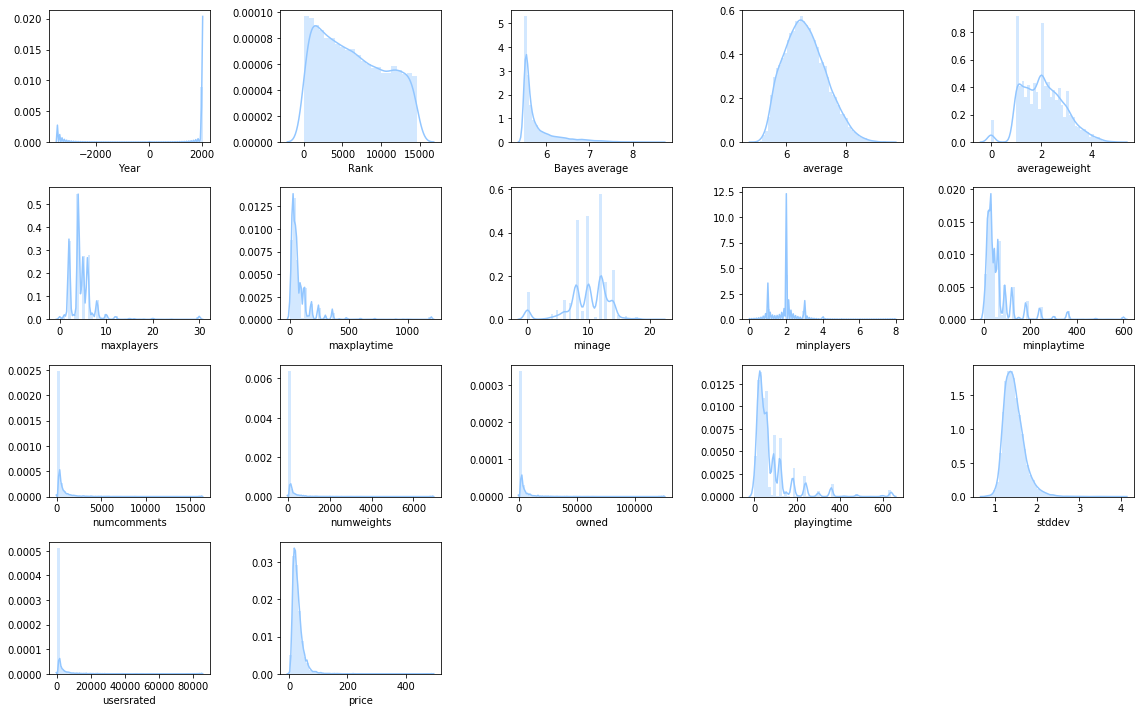

In [114]:
fig = plt.figure(figsize = (16, 10))
j = 0
for feat in features_to_examine: 
    plt.subplot(4, 5, j + 1)
    j += 1
    sns.distplot(cleaned_df[feat])
fig.tight_layout()
plt.show()

### Correlation 

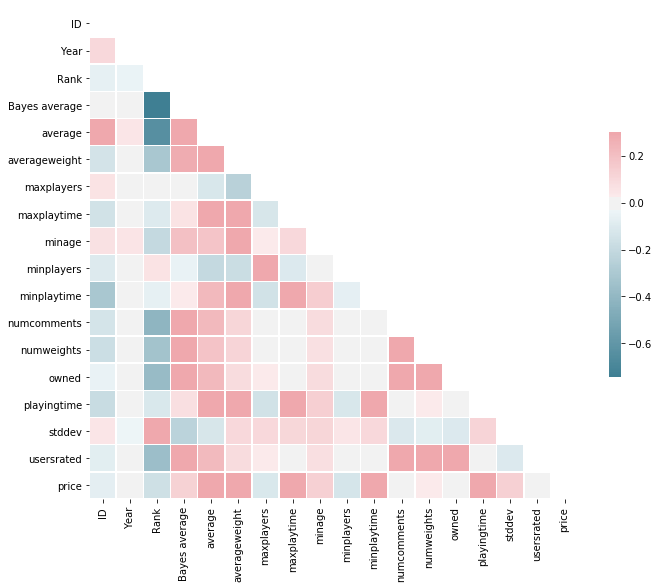

In [115]:
# Computing the correlation matrix
corr = cleaned_df.corr()

# Creating mask to cover the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Can see that there is almost no strong correlation between any of the measurements, with the exception of Bayes average and Rank displaying a moderately negative correlation. 

## Investigating influence of mechanics in a game

In [116]:
no_mechanics_df = cleaned_df[cleaned_df.boardgamemechanic.isnull()]
print("Boardgames without any mechanics listed: {}".format(len(no_mechanics_df)))

Boardgames without any mechanics listed: 607


The mechanics are to be hot encoded into binary columns before being passed to the models. This makes it hard to find the mean or medium for each value. The problem with the mean is that the encoded columns will be binary, 0 or 1, so the mean will cause futher issues in the data. The median is unlikely to work either as none of the mechanisms are likely to be found in over 50% of the data, thus the median will almost definitely be zero. 

This does introduce a third option that would avoid dropping the boardgames without any mechanics, label them just as such. When encoded, each colum will describe whether or not a specific mechanic is present in each of the games. For the games with no recorded mechanics therefore, we can experiment with leaving them in the dataset but having their mechanics set as None (ie. all the columns describing mechanics will be set to zero). 

There is an obvious pro and an obvious con to this method. The benefit is that we would no lose a significant amount of data by simply deleting these datapoints. However, the drawback might be the dilution of the information brought forward about the mechanics. 

### Encoding the mechanics

In [117]:
# Changing any NaN values to an empty string, so that these games are considered simply without any of
# the listed mechanics
cleaned_df["boardgamemechanic"] = ["None" if type(x) != str else x for x in cleaned_df.boardgamemechanic]

In [118]:
cleaned_df.head()

,ID,Name,Year,Rank,Bayes average,average,averageweight,boardgamemechanic,maxplayers,maxplaytime,minage,minplayers,minplaytime,numcomments,numweights,owned,playingtime,stddev,usersrated,price
0,174430,Gloomhaven,2017,1,8.611,8.89906,3.7930,"['Campaign / Battle Card Driven', 'Cooperative...",4,120,12,1,60,4995,1082,41470,120,1.60270,25289,88.95
1,161936,Pandemic Legacy: Season 1,2015,2,8.489,8.64165,2.8284,"['Action Point Allowance System', 'Cooperative...",4,60,13,2,60,4984,874,49878,60,1.60713,31326,51.73
2,182028,Through the Ages: A New Story of Civilization,2015,3,8.258,8.53104,4.3714,"['Action Point Allowance System', 'Auction/Bid...",4,120,14,2,120,2309,770,19551,120,1.49173,15835,36.95
3,167791,Terraforming Mars,2016,4,8.242,8.40331,3.2397,"['Card Drafting', 'Hand Management', 'Set Coll...",5,120,12,1,120,5932,1452,50512,120,1.36045,39327,46.99
4,12333,Twilight Struggle,2005,5,8.175,8.32253,3.5660,"['Area Control / Area Influence', 'Campaign / ...",2,180,13,2,120,7757,3251,47495,180,1.58575,34535,37.50


In [119]:
# cleaning the strings describing the different mechanics so that they could be successfully seperated
cleaned_df["boardgamemechanic"] = [x.replace("\'", "") for x in cleaned_df.boardgamemechanic]
cleaned_df["boardgamemechanic"] = [x.replace("[", "") for x in cleaned_df.boardgamemechanic]
cleaned_df["boardgamemechanic"] = [x.replace("]", "") for x in cleaned_df.boardgamemechanic]
cleaned_df["boardgamemechanic"] = [x.replace(" ", "") for x in cleaned_df.boardgamemechanic]

# Producing a 1 hot encoded dataframe for the different mechanics
cleaned = cleaned_df.set_index('Name').boardgamemechanic.str.split(',', expand=True).stack()
mechanics_encoded = pd.get_dummies(cleaned, prefix='mech').groupby(level=0).sum()

mechanics_encoded = mechanics_encoded.drop("mech_None", axis = 1)

# Joining the encoded mechanics back to the original dataframe
mech_join = mechanics_encoded.reset_index()
cleaned_df = cleaned_df.merge(mech_join, on = "Name")

In [120]:
mechanics_encoded.head()

,mech_Acting,mech_Action/MovementProgramming,mech_ActionPointAllowanceSystem,mech_Area-Impulse,mech_AreaControl/AreaInfluence,mech_AreaEnclosure,mech_AreaMovement,mech_Auction/Bidding,mech_Betting/Wagering,mech_Campaign/BattleCardDriven,...,mech_Storytelling,mech_TakeThat,mech_TilePlacement,mech_TimeTrack,mech_Trading,mech_Trick-taking,mech_VariablePhaseOrder,mech_VariablePlayerPowers,mech_Voting,mech_WorkerPlacement
Name,,,,,,,,,,,,,,,,,,,,,
"""Oh My God! There's An Axe In My Head."" The Game of International Diplomacy",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
"""Tarleton's Quarter!""",0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'65: Squad-Level Combat in the Jungles of Vietnam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*Star,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"...and then, we held hands.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Correlation between mechanics

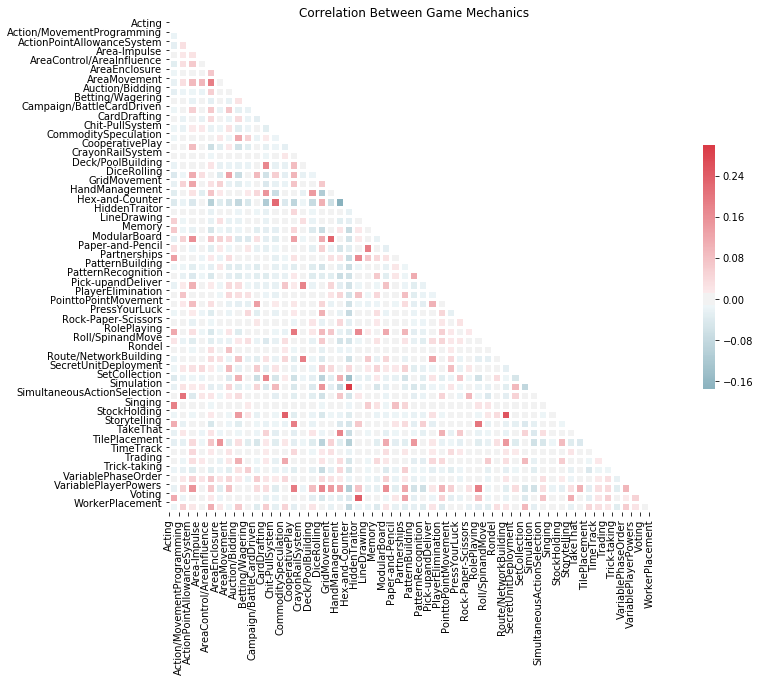

In [121]:
# Heat map of correlation 
mech_corr = mechanics_encoded.corr()
mechanic_names = [x.lstrip("mech_") for x in mechanics_encoded]
# Creating mask to cover the upper triangle
mask = np.triu(np.ones_like(mech_corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(mech_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=2, cbar_kws={"shrink": .5})

plt.yticks(range(len(mechanic_names)), mechanic_names)
plt.xticks(range(len(mechanic_names)), mechanic_names, rotation = 90)
plt.title("Correlation Between Game Mechanics")
plt.show()

Whilst crowded, the heat map shows that there is very little significant correlation/overlap between any of the boardgame mechanics.

### Analysing influence of mechanics

In [122]:
# Finding and cleaning the strings associated with the mechanics
mechanics = []
for mech in cleaned_df.boardgamemechanic:
    if type(mech) == str:
        seperated_mech = mech.split(",")
        for i in seperated_mech:
            cleaned_mech = i.strip(' \'[]') 

            if cleaned_mech not in mechanics:
                mechanics.append(cleaned_mech)


In [123]:
mech_avg = np.zeros(len(mechanics))
mech_avg_std = np.zeros(len(mechanics))
mech_avg_weight = np.zeros(len(mechanics))
mech_weight_std = np.zeros(len(mechanics))
mech_count = np.zeros(len(mechanics))
mech_price = np.zeros(len(mechanics))
mech_price_std = np.zeros(len(mechanics))

for i, mech in enumerate(mechanics):
    games_of_interest = cleaned_df[cleaned_df["boardgamemechanic"].str.contains(mech)] 
    
    # find average score and its standard deviation
    mech_avg[i] = games_of_interest.average.mean()
    mech_avg_std[i] = games_of_interest.average.std()
    
    # find weight and its standard deviation
    mech_avg_weight[i] = games_of_interest.averageweight.mean()
    mech_weight_std[i] = games_of_interest.averageweight.std()

    # find count
    mech_count[i] = games_of_interest.Name.count()
    
    # find price and its standard deviation
    mech_price[i] = games_of_interest.price.mean()
    mech_price_std[i] = games_of_interest.price.std()

In [124]:
mech_df = pd.DataFrame()
mech_df["Mechanic"] = mechanics
mech_df["Average_Score"] = mech_avg
mech_df["Score_Std"] = mech_avg_std
mech_df["Average_Weight"] = mech_avg_weight
mech_df["Weight_Std"] = mech_weight_std
mech_df["Count"] = mech_count
mech_df["Price"] = mech_price
mech_df["Price_Std"] = mech_price_std

In [125]:
mech_df.head()

,Mechanic,Average_Score,Score_Std,Average_Weight,Weight_Std,Count,Price,Price_Std
0,Campaign/BattleCardDriven,7.153674,0.730107,2.708154,0.715733,299.0,43.452253,19.731737
1,CooperativePlay,6.987462,0.714518,2.180876,0.841383,712.0,34.014747,31.011684
2,GridMovement,6.942271,0.685191,2.369345,0.691144,520.0,34.876738,33.710144
3,HandManagement,6.708165,0.655911,2.039241,0.726389,2373.0,26.423029,17.166191
4,ModularBoard,6.850931,0.721474,2.391638,0.738251,916.0,35.913017,20.489862


#### Mechanics: Price

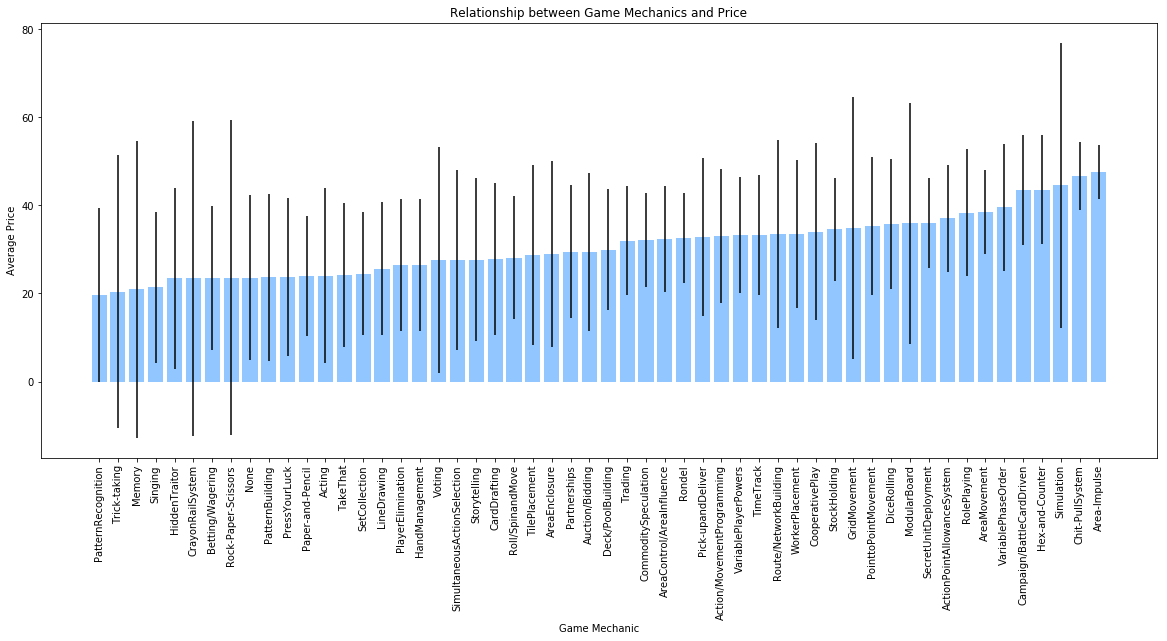

In [126]:
plt.figure(figsize = (20, 8))

plt.style.use('seaborn-pastel')
idx = np.argsort(mech_df.Price)
plt.bar(range(len(mech_df)), mech_df.Price[idx])
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)
plt.errorbar(x = range(len(mech_df)), y = mech_df.Price[idx], yerr = mech_df.Price_Std, c = 'k', linestyle = "None")
plt.xlabel("Game Mechanic")
plt.ylabel("Average Price")
plt.title("Relationship between Game Mechanics and Price")
plt.show()

#### Mechanics: Score

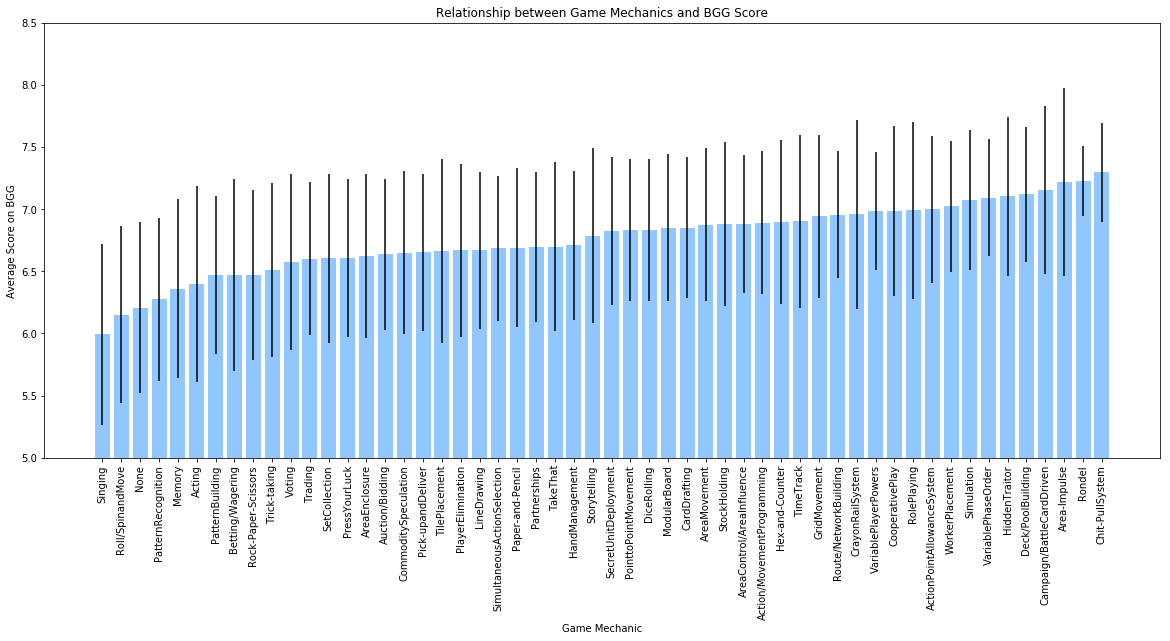

In [127]:
plt.figure(figsize = (20, 8))

plt.style.use('seaborn-pastel')
idx = np.argsort(mech_df.Average_Score)
plt.bar(range(len(mech_df)), mech_df.Average_Score[idx])
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)
plt.errorbar(x = range(len(mech_df)), y = mech_df.Average_Score[idx], yerr = mech_df.Score_Std, c = 'k', linestyle = "None")
plt.xlabel("Game Mechanic")
plt.ylabel("Average Score on BGG")
plt.title("Relationship between Game Mechanics and BGG Score")
plt.ylim(5, 8.5)
plt.show()

#### Mechanics: Weight

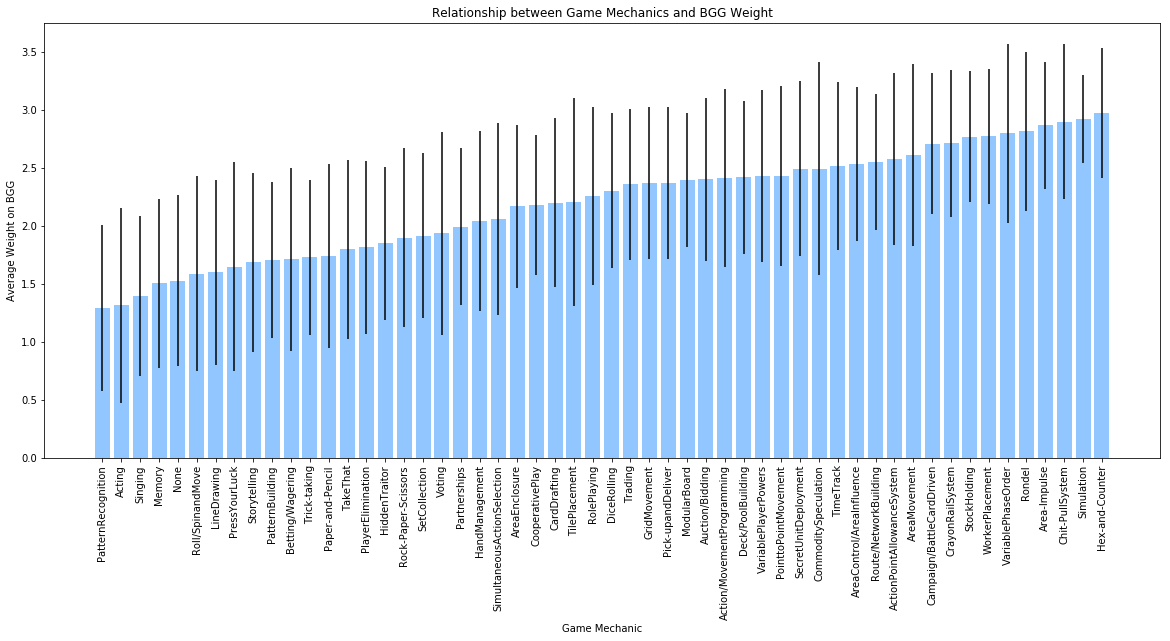

In [128]:
plt.figure(figsize = (20, 8))

idx = np.argsort(mech_df.Average_Weight)
plt.bar(range(len(mech_df)), mech_df.Average_Weight[idx])
plt.errorbar(x = range(len(mech_df)), y = mech_df.Average_Weight[idx], yerr = mech_df.Weight_Std, c = 'k', linestyle = "None")
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)

plt.xlabel("Game Mechanic")
plt.ylabel("Average Weight on BGG")
plt.title("Relationship between Game Mechanics and BGG Weight")


plt.show()

It can be seen that the standard deviation of the price, weight and score across different mechanics is massive. This has the potential side effect of weakening any models applied to this data.

#### Mechanics: Count

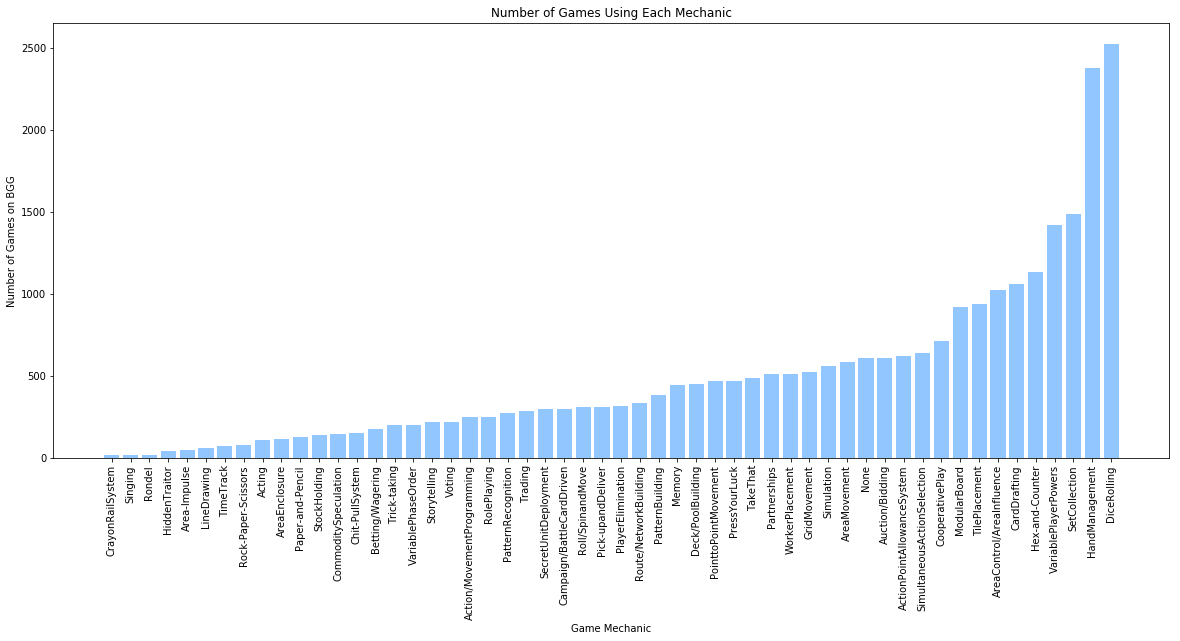

In [129]:
plt.figure(figsize = (20, 8))

idx = np.argsort(mech_df.Count)
plt.bar(range(len(mech_df)), mech_df.Count[idx])
plt.xticks(range(len(mech_df)), np.array(mech_df.Mechanic)[idx], rotation = 90)

plt.xlabel("Game Mechanic")
plt.ylabel("Number of Games on BGG")
plt.title("Number of Games Using Each Mechanic")


plt.show()

# Price predictor: 

Multiple SciKit-Learn models will be experimented with to investigate the datasets potential to predict the price of the game in question. 

In [227]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from pprint import pprint

#### Splitting the data into train, validation and test

Need to clean up the dataframe so that it is suitable for the machine learning method:
* [x] No need for Names, mechanisms or ID
* [x] Sort mechanisms into seperate columns 
* [x]Check to see if there is any linear correlation between measurements - can ditch one of them to help with linear regression. 

Splitting the data into training and testing

In [132]:
ml_data = cleaned_df.copy()
# Removing the name and ID 
ml_data = ml_data.drop(["Name", "ID", "boardgamemechanic"], axis = 1)

In [133]:
ml_data.head()

,Year,Rank,Bayes average,average,averageweight,maxplayers,maxplaytime,minage,minplayers,minplaytime,...,mech_Storytelling,mech_TakeThat,mech_TilePlacement,mech_TimeTrack,mech_Trading,mech_Trick-taking,mech_VariablePhaseOrder,mech_VariablePlayerPowers,mech_Voting,mech_WorkerPlacement
0,2017,1,8.611,8.89906,3.7930,4,120,12,1,60,...,1,0,0,0,0,0,0,1,0,0
1,2015,2,8.489,8.64165,2.8284,4,60,13,2,60,...,0,0,0,0,1,0,0,1,0,0
2,2015,3,8.258,8.53104,4.3714,4,120,14,2,120,...,0,0,0,0,0,0,0,0,0,0
3,2016,4,8.242,8.40331,3.2397,5,120,12,1,120,...,0,1,1,0,0,0,0,1,0,0
4,2005,5,8.175,8.32253,3.5660,2,180,13,2,120,...,0,0,0,0,0,0,0,0,0,0


##### Correlation between measurements

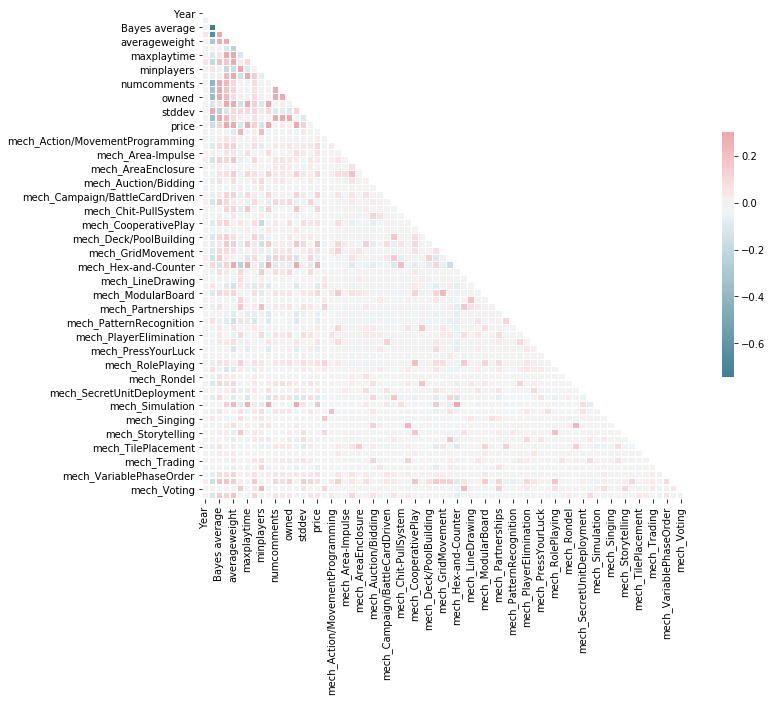

In [134]:
# Computing the correlation matrix
corr = ml_data.corr()

# Creating mask to cover the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

It can be seen that whilst some values have a degree of negative correlation (e.g. rank and price, or rank and average score), none of the measurements are sufficiently correlated (>0.9) for it to be worthwhile to remove any measurements.

In [135]:
X = ml_data.copy().drop("price", axis = 1)
Y = ml_data.price

In [137]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33)

### Multiple Linear Regression

#### Stats models:

In [140]:
x_sm = sm.add_constant(x_train)
ols_model = sm.OLS(y_train, x_sm)
ols_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     47.20
Date:                Thu, 16 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:12:51   Log-Likelihood:                -28527.
No. Observations:                6787   AIC:                         5.719e+04
Df Residuals:                    6717   BIC:                         5.767e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                              -44.0968      7.017     -6.285      0.000     -57.852     -30.342
Year                                 0.0004      0.001      0.297      0.767      -0.002       0.003
Rank                                 0.0002    8.9e-05      2.206      0.027    2.19e-05       0.000
Bayes average                        0.5362      0.980      0.547      0.584      -1.385       2.457
average                              6.5719      0.461     14.244      0.000       5.667       7.476
averageweight                        4.1544      0.389     10.687      0.000       3.392       4.916
maxplayers                           0.0140      0.074      0.191      0.849      -0.130       0.158
maxplaytime                          0.0369      0.006      6.469      0.000       0.026       0.048
minage                               0.1357      0.064      2.127      0.033       0.011       0.261
minplayers                          -0.2273      0.350     -0.650      0.516      -0.913       0.458
minplaytime                          0.0040      0.006      0.719      0.472      -0.007       0.015
numcomments                          0.0051      0.002      2.659      0.008       0.001       0.009
numweights                          -0.0050      0.004     -1.367      0.172      -0.012       0.002
owned                               -0.0013      0.000     -4.648      0.000      -0.002      -0.001
playingtime                         -0.0086      0.009     -0.922      0.357      -0.027       0.010
stddev                               7.5635      0.953      7.940      0.000       5.696       9.431
usersrated                           0.0009      0.000      1.892      0.059   -3.34e-05       0.002
mech_Acting                         -1.9564      2.150     -0.910      0.363      -6.170       2.258
mech_Action/MovementProgramming      0.5978      1.323      0.452      0.652      -1.997       3.192
mech_ActionPointAllowanceSystem      1.0940      0.843      1.298      0.194      -0.559       2.747
mech_Area-Impulse                    4.6694      2.781      1.679      0.093      -0.783      10.122
mech_AreaControl/AreaInfluence      -0.8459      0.678     -1.247      0.213      -2.176       0.484
mech_AreaEnclosure                   0.8902      1.872      0.476      0.634      -2.779       4.560
mech_AreaMovement                    2.8798      0.867      3.323      0.001       1.181       4.579
mech_Auction/Bidding                 0.4385      0.832      0.527      0.598      -1.193       2.070
mech_Betting/Wagering               -1.4792      1.455     -1.016      0.309      -4.332       1.374
mech_Campaign/BattleCardDriven       4.3236      1.187      3.644      0.000       1.998       6.650
mech_CardDrafting                   -0.3549      0.68

From the summary we can see that the R-squared value is only ~0.3, which is significantly low, indicating the model can only account for 33.7% of the variation seen in the price. 

Significant (p-val < 0.05) labels in our model: 
* Year - Newer games seem to be ever so slightly cheaper. 
* Rank - The higher the rank, the more expensive a game is. 
* Average Score - Significantly increases the value of the game, about £7 for every additional point in its score.
* Average Weight - Also increases the value of the game by £4 per weight-value. This is likely due to higher complexity games requiring additional components, thus increasing the manufacturing cost of the game. 
* max_playtime also increased price slightly. 
* Several of the mechanics showed significant influence in the model as well. 

#### Sklearn:

In [141]:
cv_amount = 10 # Cross validation 

In [142]:
lm = LinearRegression()
lm.fit(x_train, y_train)

avg_error = cross_val_score(lm, x_train, y_train, scoring = "neg_mean_absolute_error", cv = cv_amount).mean()

In [143]:
print("On average, the linear regression model is predicting the price off by £{}".format(round(avg_error, 2)))

On average, the linear regression model is predicting the price off by £-9.92


Mean absolute error was used as I do not want outliers in the data to have as significant impact as when mean squared error is used.

## Lasso Regression

In [144]:
lm_l = Lasso()
lm_l.fit(x_train, y_train)
lasso_error = cross_val_score(lm_l, x_train, y_train, scoring = "neg_mean_absolute_error", cv = cv_amount).mean()

In [145]:
print("On average, the lasso model is predicting the price off by £{}".format(round(lasso_error, 2)))

On average, the lasso model is predicting the price off by £-10.22


In [148]:
# Varying the alpha value for lasso: 
alpha = []
alpha_error = []
for i in np.arange(0.01, 5, 0.25):
    alpha.append(i)
    lm_l = Lasso(alpha = i)
    lm_l.fit(x_train, y_train)
    lasso_error = cross_val_score(lm_l, x_train, y_train, scoring = "neg_mean_absolute_error", cv =cv_amount).mean()    
    alpha_error.append(lasso_error)

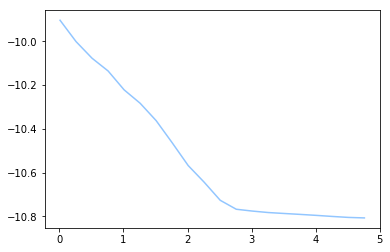

In [149]:
plt.plot(alpha, alpha_error)
plt.show()

## Random Forest

In [231]:
forest = RandomForestRegressor(random_state=42)
forest.fit(x_train, y_train)
rf_cv_score = cross_val_score(forest, x_train, y_train,scoring = "neg_mean_absolute_error", cv = cv_amount).mean()

In [232]:
print(rf_cv_score)

-10.1257044953


In [233]:
# Current hyper parameters in use: 
print('Parameters currently in use:\n')
pprint(forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [236]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [238]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 56.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 135.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

# Tune models using grid search: 
rf_parameters = {"n_estimators": range(10, 100, 20)}#, 'max_features':('auto', 'sqrt', 'log2')}
gs = GridSearchCV(forest, rf_parameters, scoring = "neg_mean_absolute_error", cv = cv_amount)
rf_output = gs.fit(x_train, y_train)


Comparing the results:

In [213]:
y_pred_lm = lm.predict(x_test)
y_pred_lm_l = lm_l.predict(x_test)
y_pred_rf = forest.predict(x_test)

In [214]:
lm_error = mean_absolute_error(y_pred_lm, y_test)
lm_l_error = mean_absolute_error(y_pred_lm_l, y_test)
rf_error = mean_absolute_error(y_pred_rf, y_test)

In [215]:
print("Mean Absolute Errors:")
print("Linear Regression: {}".format(lm_error))
print("Lasso Regression: {}".format(lm_l_error))
print("Random Forest: {}".format(rf_error))

Mean Absolute Errors:
Linear Regression: 10.078302126977235
Lasso Regression: 11.007684940764658
Random Forest: 10.204556481758376


## Model Stacking: 

Very basic stacking, given there are only two reasonable models.

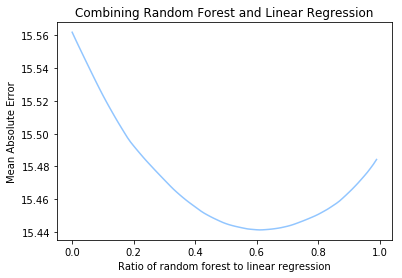

Optimal ratio involves 61.0% random forest and 39.0% linear regression


15.441352539066425

In [225]:
ratio_vals = np.arange(0, 1, 0.01)
ratio_errors = np.zeros(len(ratio_vals))
for i, ratio in enumerate(ratio_vals):
    A = y_pred_rf * ratio 
    B = y_pred_lm * (1 - ratio)
    combined_pred = (A + B)/2
    ratio_errors[i] = mean_absolute_error(combined_pred, y_test).mean()
    
plt.plot(ratio_vals, ratio_errors)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Ratio of random forest to linear regression")
plt.title("Combining Random Forest and Linear Regression")
plt.show()

optimal_ratio = ratio_vals[np.argmin(ratio_errors)]

print("Optimal ratio involves {}% random forest and {}% linear regression".format(round(optimal_ratio*100), round(100 - optimal_ratio*100)))
mean_absolute_error((optimal_ratio * y_pred_rf + (1 - optimal_ratio) * y_pred_lm)/2, y_test)

Use the Random forest and Linear Regression (level 0) to predict the prices for all the data's prices.
Then use a third model (level 1) to take those predictions and learn the best way to take a weighted average from the level 0 predictions. 

In [216]:
cv = KFold(n_splits=10, random_state=42, shuffle=False)
cv.get_n_splits(x_train)

training_predictions = np.zeros((len(y_train), 2)) 

for train_index, val_index in cv.split(x_train):
    x_train_sub = x_train.values[train_index]
    y_train_sub = y_train.values[train_index]
    x_val_sub = x_train.values[val_index]

    lm = LinearRegression().fit(x_train_sub, y_train_sub)
    rf = RandomForestRegressor().fit(x_train_sub, y_train_sub)

    training_predictions[val_index, 0] = lm.predict(x_val_sub)
    training_predictions[val_index, 1] = rf.predict(x_val_sub)

test_predictions = np.concatenate([y_pred_lm.reshape(-1, 1), y_pred_rf.reshape(-1, 1)], axis = 1)    

meta_lm = LinearRegression()
meta_lm.fit(training_predictions, y_train)

meta_test_pred = meta_lm.predict(test_predictions)

ensemble_error = mean_absolute_error(meta_test_pred, y_test)

print("Mean Absolute Error from stacked models:")
print("£{}".format(round(ensemble_error, 4)))

Mean Absolute Error from stacked models:
£9.7431


In [196]:
class Stacked:
    def __init__(self):
        self.self = self
        
    def fit(self, x_train, y_train):
        
        # Getting predictions for test data:
        self.lm = LinearRegression().fit(x_train, y_train)
        self.rf = RandomForestRegressor().fit(x_train, y_train)

        y_pred_lm = self.lm.predict(x_test)
        y_pred_rf = self.rf.predict(x_test)
        test_predictions = np.concatenate([y_pred_lm.reshape(-1, 1), y_pred_rf.reshape(-1, 1)], axis = 1)
        
        
        # Getting predictions for training data through cross validation:
        cv = KFold(n_splits=10, random_state=42, shuffle=False)
        cv.get_n_splits(x_train)

        training_predictions = np.zeros((len(y_train), 2)) 

        for train_index, val_index in cv.split(x_train):
            # Splitting the training data into further training and validation data
            x_train_sub = x_train.values[train_index]
            y_train_sub = y_train.values[train_index]
            x_val_sub = x_train.values[val_index]
            
            # Training the models
            sub_lm = LinearRegression().fit(x_train_sub, y_train_sub)
            sub_rf = RandomForestRegressor().fit(x_train_sub, y_train_sub)
            
            # Predicting the validation data and keeping the results. 
            training_predictions[val_index, 0] = sub_lm.predict(x_val_sub)
            training_predictions[val_index, 1] = sub_rf.predict(x_val_sub)

        self.meta_lm = LinearRegression().fit(training_predictions, y_train)
    
    def predict(self, x_test):
        lm_pred = self.lm.predict(x_test)
        rf_pred = self.lm.predict(x_test)
        lvl_0_pred = np.concatenate([lm_pred.reshape(-1, 1), rf_pred.reshape(-1, 1)], axis = 1)
        lvl_1_pred = self.meta_lm.predict(lvl_0_pred) 
        return lvl_1_pred
    

In [197]:
stacked_predictor = Stacked()
stacked_predictor.fit(x_train, y_train)
stacked_predictions = stacked_predictor.predict(x_test)
mean_absolute_error(stacked_predictions, y_test).mean()

10.021788234495864

### Outcome and Conclusion:

All 3 models showed a mean absolute error of ~£10, which isn't amazing as most boardgames fall between £20-40. The likely reason for this is that some of the major factors in boardgame pricing were not accounted for in the dataset. Specifically, where the game is produced, the game-component quality and whether it is still in production. 

As a very profit-low industry, many boardgames are produced by smaller businesses in a labour of love. Often they will not take off in the vast numbers required for the game to be produced in bulk and outsourced to a cheaper labour force (found in countries such as China). As a result, they will often be produced in smaller batches in countries with a higher cost of labour (such as germany). 

On the topic of production, the components quality and quantity within a game will have a major factor on pricing. Take the top rated game in this dataset, Gloomhaven, which contains 1,500 cards in a box which when full weighs almost 10 kg (22 pounds), that's the equivalent weight of 11 boxes of monopoly. All these components cause Gloomhaven to be sold for a whopping £100+. Yet, the closest metric in this dataset to convey this abundence in components is the 'Weight' given to the game. Often, the games with a higher weight facilitate this complexity through large boards, many pieces etc, however this is really not a hard or fast rule. 

The third rule comes down to basic supply and demand. As mentioned above, many boardgames are not produced in vast quantities, instead aiming to produce just below the expected demand. Even when a game is popular, it is often just not profitable enough for a second or third batch of the game to manufactured. This leads to a limited supply and so forces the price of the remaining copies of successful game to grow massively.



The ensemble of random forest and linear regression did show a minor improvement in price prediction, but not significant enough to get excited about. 

It has been an interesting project and I feel like I have learnt some both major and minor lessons which I had not considered before in this sort of project, with three sticking clearly in my mind.

Firstly, the fact that ethically webscraping can be a long process if amount of information per request is low. I did not want to put any unnecessary strain on boardgameprices.co.uk and so the webscraping for 1000s of games took days. In retrospect, I could have probably collected fewer data and still acheived a similar level of accuracy in the predictive models. 

Taking for granted any aspect of the data's distribution. Whilst obvious, this projected acted as a gentle reminder of the importance of thoroughly cleaning one's data. In particular, metrics such as the maximum number of players were distributed wildly with some games having a maximum player count of 1000! 

And thirdly, the many different methods of encoding categorical data at your disposal when formatting a dataset. With around 50 different boardgame mechanics found in the dataset, I had to consider the impact that adding that many dimensions to a dataset might have. Whilst I eventually just settled for one-hot encoding, it was an educational experience to investigate the different options out there. 
